# Sumário
- [Importando as bibliotecas](#Importando-as-bibliotecas)
* [Plotando os dados](#Plotando-os-dados)
    * [Função para plotar os gráficos](#Função-para-plotar-os-gráficos)
    * [Gráficos de distribuição dos dados](#Gráficos-de-distribuição-dos-dados)
    * [Gráfico com várias colunas](#Gráfico-com-várias-colunas)
- [Normalizando os Dados](#Normalizando-os-Dados)
- [Divisão dos dados](#Divisão-dos-dados)
* [Gerando dados sintéticos](#Gerando-dados-sintéticos)
- [Modelo](#Modelo)
- [Otimizadores](#Otimizadores)
- [criando o modelo](#criando-o-modelo)
- [Treinamento do modelo](#Treinamento-do-modelo)
- [Conversão do modelo para JSON](#Conversão-do-modelo-para-JSON)
-[Submetendo a solução](#Submetendo-a-solução)

# Importando as bibliotecas

In [209]:
import pandas as pd
import tensorflow
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import datetime
import random
from imblearn.over_sampling import RandomOverSampler

# fonte do banco de dados:
# https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon/#ProblemStatement


# for jupyter
%matplotlib inline

In [210]:
# importar os dados
dt = pd.read_csv('train.csv')
dt.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


# Plotando os dados

### Função para plotar os gráficos

In [211]:
def strokes(x,v = 1):
    """ função para filtrar a base de dados e retornar apenas pacientes que sofreram ou não AVC """
    r = x[x['stroke'] == v ]
    return r

def change_text(text):
    """
        Melhorar a exibição dos valores das abcissas
    """
    if isinstance(text,str):
        # tratar textos longos, permitir a quebra da linha
        return text.replace(' ','\n').replace('_','\n').replace('-','\n')
    elif (isinstance(text,int)) or  (isinstance(text,(int, np.integer))): 
        # traduzir valores binários
        return "Yes" if text == 1 else "No"
    elif text == None:
        return "Null"
    else:
        return text

 
    
def distribuicao(x,col=None):
    """
        Cria um gráfico de distribuição em função da coluna e avc, isto é,
        cada valor diferente da coluna será gerada duas barras, uma com pacientes com avc uma sem
    """
    
    # tamanho da figura a ser exibida
    plt.rcParams["figure.figsize"] = (10,5)
    
    # espaçamento entre cada valor
    x_space = 3;
    
    xs = [None]
    if col != None:
        # valores possíveis do conjunto domínio
        xs = x[col].unique()
    
    # porcentagem da distribuição de cada domínio com AVC
    percents = []
    
    # labels a serem adicionados na legenda
    labels = ["no stroke","suffered stroke"]
    
    # vamos percorrer cada domínio
    for i,vx in enumerate(xs):
        classe = x;
        
        if vx != None:
            # filtrar o dataset apenas com a coluna desejada
            classe = x[ x[col] == vx ]

            # tratar a coluna com registros nulos
            if str(vx)== "nan":
                classe = x[ dt[col].apply(lambda a: True if str(a) == "nan" else False)  ]

        # pegar a quantidade de elementos com stroke = 1 e = 0, respectivamente, em função do domínio
        p, n = len(strokes(classe,1)), len(strokes(classe,0))

        # criar as barras no gráfico
        plt.bar([(i*x_space)],[n], color='g', label=labels[0])
        plt.bar([(i*x_space)+1],[p], color='r', label=labels[1])
        
        # garantir que a próxima legenda de outro domínio não seja inserida
        labels = None, None
        
        # calcular a porcentagem de cada domínio
        percent = 0
        if p+n > 0:
            percent = round((p/(p+n))*100,2)
        #armazenar numa lista, já com os locais para desenhar
        percents.append( [ percent, p, (i*x_space)+1, max(p,n)] )
    
    #adicionar título ao gráfico
    plt.title(col+" distribution" if col!=None else "Distribution",fontsize=20)
    
    # adicionar os labels do eixo das abscissas
    if (xs[0] != None) and (len(xs) > 1):
        plt.xticks(ticks=[ (i*x_space)+0.5 for i,x in enumerate(xs)], labels=[change_text(i) for i in xs],fontsize=20)
    
    # adicioanr as porcentagens das distribuições com avc
    for v in percents:
        plt.text(v[2], v[1]+ max(percents,key=lambda b: b[3])[3]*0.02, str(v[0])+"%", fontsize=11, horizontalalignment='center')
    
    
    # mostrar a legenda
    plt.legend(loc="best")
    # mostrar o gráfico
    plt.show( )

### Gráficos de distribuição dos dados

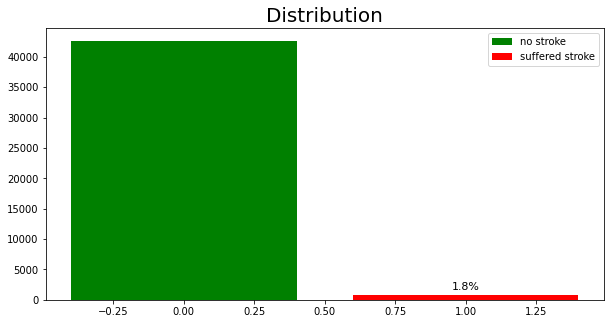

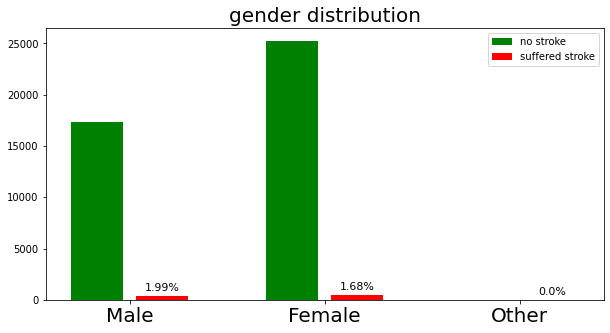

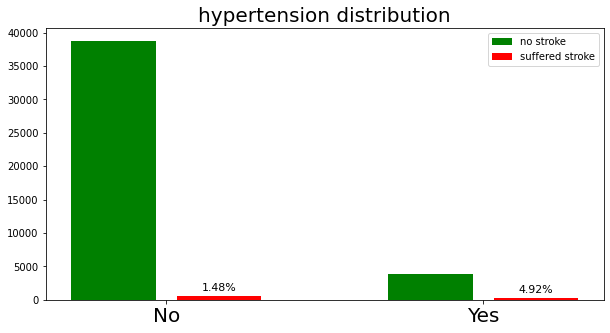

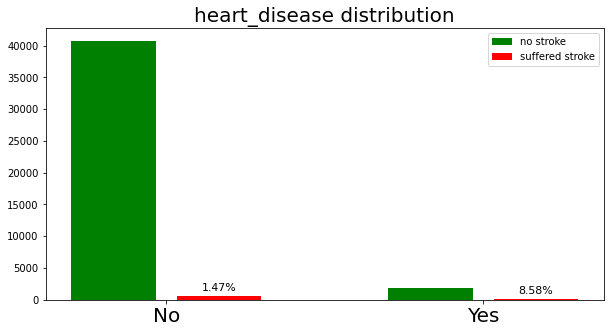

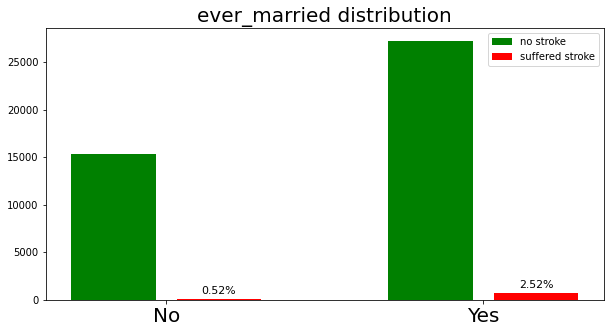

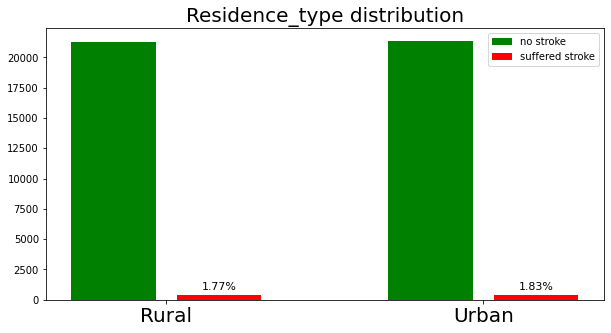

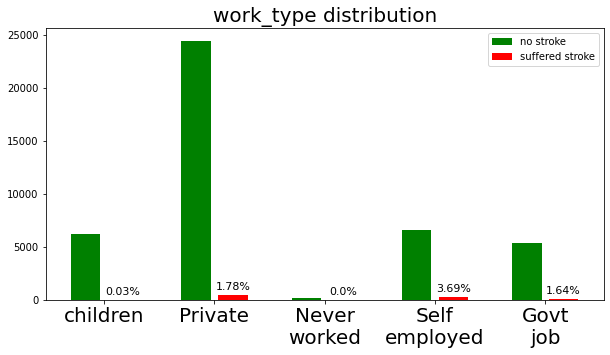

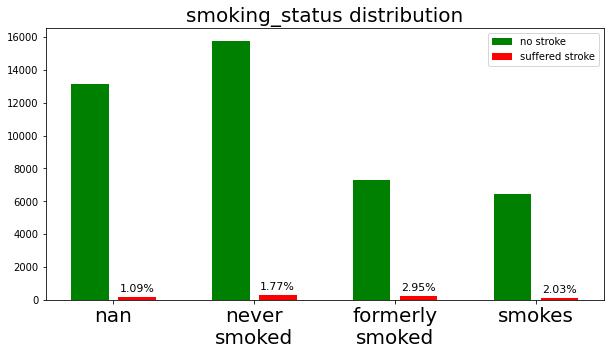

In [212]:
# mostrar a distribuição de cada coluna
l = [None,"gender","hypertension","heart_disease","ever_married","Residence_type","work_type","smoking_status"]
for i in l:
    distribuicao(dt,i)

### Gráfico com várias colunas

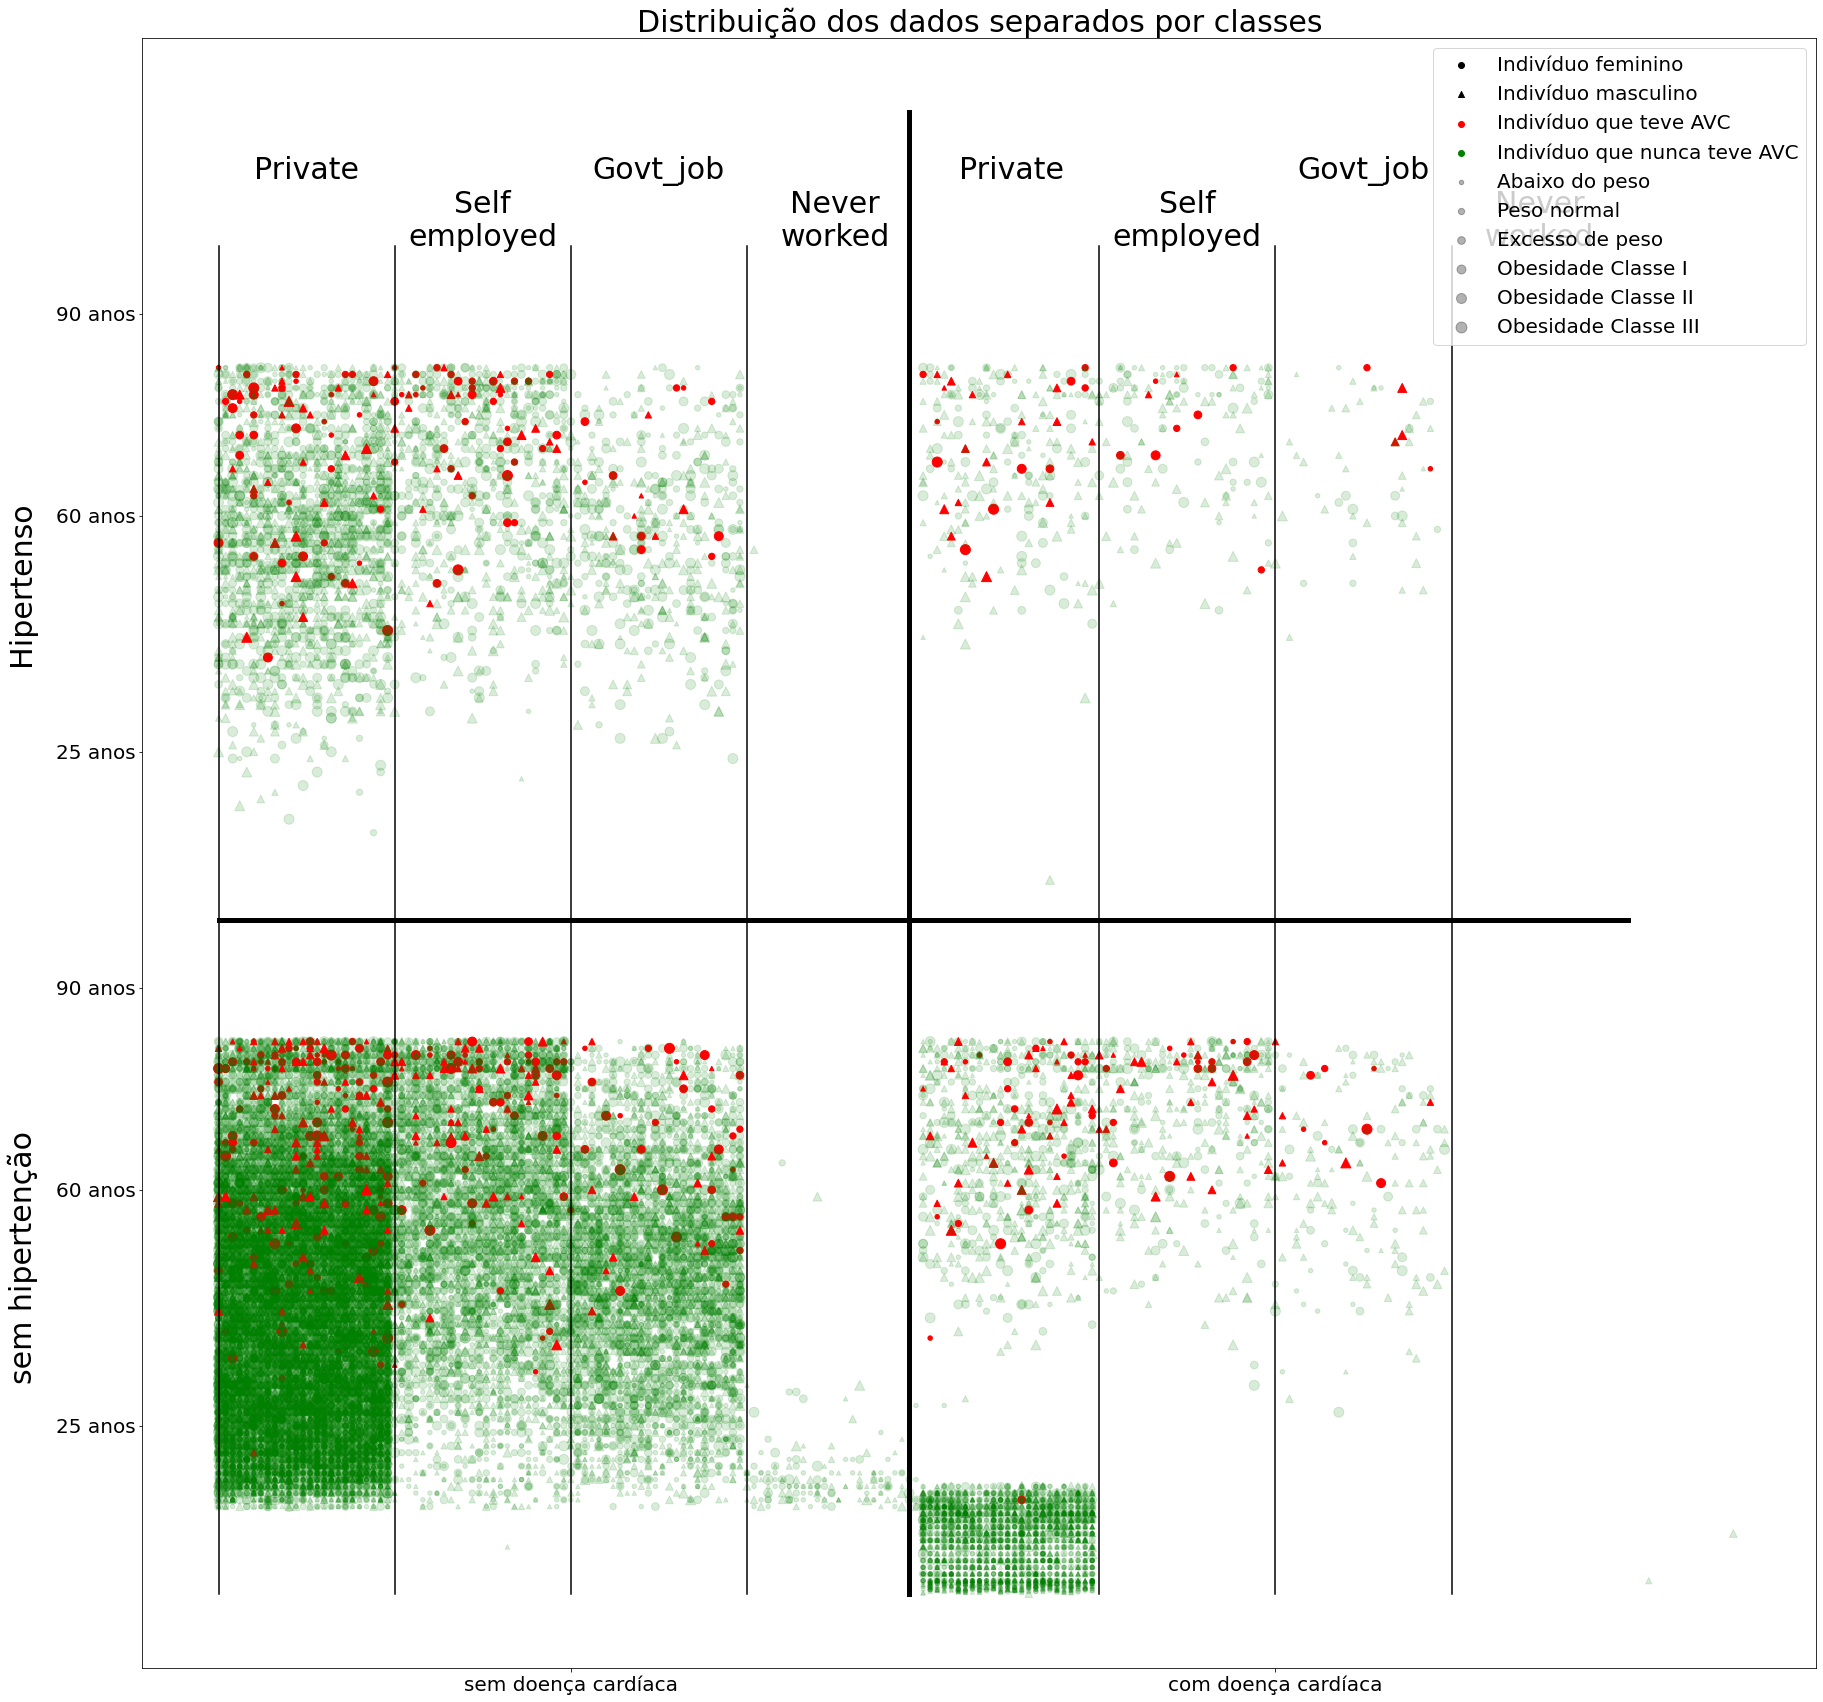

In [213]:
"""
    Vamos tentar plotar um gráfico com informações sobre várias colunas
"""


# muda o tamanho da figura do gráfico
plt.rcParams["figure.figsize"] = (30,30)

# cria uma lista com os tipos de trabalo
lista = ['Private', 'Self-employed', 'Govt_job', 'Never_worked',"children"]


#criar uma copia do dataset
data_print = dt.copy();


def set_imc_class(value):
    """
        Retornar o indice de obesidade em funcao do IMC
    """
    lista_obsidade = [18.5, 25, 30,35,40, 9999]
    for i,v in enumerate(lista_obsidade):
        if value < v:
            return i*20
        
        
#criar colunas com valores específicos para plotagem
#tipo de trabalho
data_print['work'] = data_print['work_type'].apply(lambda x: lista.index(x))
#criar uma cor para cada linha
data_print['cor'] = data_print['stroke'].apply(lambda x:'r' if x == 1 else 'g')
#aplicar um alpha diferente para os positivados
data_print['alpha'] = data_print['stroke'].apply(lambda x:0.15 if x == 0 else 1)
#utilizar o o tamanho de cada linha no gráfico como o grupo de obesidade
data_print['imc_class'] = data_print["bmi"].apply(set_imc_class )
#criar uma coluna para ordenar os hipertensos pela idade
data_print['hyper_age'] = (data_print['hypertension'])+(data_print['age']/100)
# coloca os pacientes com doença cardíaca na faixa de grupo específico
data_print['heart_work'] = data_print['heart_disease']+(data_print['work'].apply(lambda x: (x/4) + (random.randrange(0,25)/100) ))


# divide o dataset para colocar símbolos diferentes
data_F = data_print[data_print['gender'] == 'Female'].copy()
data_M = data_print[data_print['gender'] == 'Male'].copy()


#plota o gênero feminino
plt.scatter(y=data_F['hyper_age'],  # eixo y
            x=data_F['heart_work'], # eixo x
            c=data_F['cor'],        # cor de cada registro
            alpha=data_F['alpha'],  # transparência de cada registro
            marker='o',             # símbolo do conjunto de dados
            s=data_F['imc_class'],  # tamanho de cada registro
           )

#plota o gênero masculino
plt.scatter(y=data_M['hyper_age'], 
            x=data_M['heart_work'], 
            c=data_M['cor'], 
            alpha=data_M['alpha'], 
            marker='^', 
            s=data_M['imc_class'],
           )
    
# define os labels do eixo X
plt.xticks(ticks=[0.5,1.5], labels=["sem doença cardíaca","com doença cardíaca"],fontsize=20)
# define os labels do eixo y
plt.yticks(ticks=[0.25,0.6,0.9, 1.25, 1.6,1.9], labels=["25 anos", "60 anos","90 anos","25 anos", "60 anos","90 anos"],fontsize=20)

# Informações sobre o eixo das ordenadas
plt.text(-0.3, 0.5, "sem hipertenção", fontsize=30,  rotation='vertical',  verticalalignment='center')
plt.text(-0.3, 1.5, "Hipertenso", fontsize=30,  rotation='vertical',  verticalalignment='center')

# linha para dividir a doença cardíaca
plt.plot( [0.98,0.98] , [0,2.2], linestyle='solid', c="black", linewidth=5)  
# linha para dividir os hipertensos
plt.plot( [0,2] , [1,1], linestyle='solid', c="black", linewidth=5)  


#linha para dividir os tipos de trabalho dos pacintes sem doença cardíaca
plt.plot( [0.00,0.00] , [0.0,2.], linestyle='solid', c="black")
plt.plot( [0.25,0.25] , [0.0,2.], linestyle='solid', c="black")  
plt.plot( [0.50,0.50] , [0.0,2.], linestyle='solid', c="black")  
plt.plot( [0.75,0.75] , [0.0,2.], linestyle='solid', c="black")  

#linha para dividir os tipos de trabalho dos pacintes com doença cardíaca
plt.plot( [0.98,0.98] , [0.0,2.], linestyle='solid', c="black")
plt.plot( [1.25,1.25] , [0.0,2.], linestyle='solid', c="black")  
plt.plot( [1.50,1.50] , [0.0,2.], linestyle='solid', c="black")  
plt.plot( [1.75,1.75] , [0.0,2.], linestyle='solid', c="black")  


# escrever cada grupo de trabalho, pacientes sem doença cardíaca
plt.text(   0+0.125, 2.1, "Private", fontsize=30,  horizontalalignment='center')
plt.text(0.25+0.125, 2.0, "Self\nemployed", fontsize=30,  horizontalalignment='center')
plt.text(0.50+0.125, 2.1, "Govt_job", fontsize=30,  horizontalalignment='center')
plt.text(0.75+0.125, 2.0, "Never\nworked", fontsize=30,  horizontalalignment='center')
# escrever cada grupo de trabalho, pacientes com doença cardíaca
plt.text(   0+1.125, 2.1, "Private", fontsize=30,  horizontalalignment='center')
plt.text(0.25+1.125, 2.0, "Self\nemployed", fontsize=30,  horizontalalignment='center')
plt.text(0.50+1.125, 2.1, "Govt_job", fontsize=30,  horizontalalignment='center')
plt.text(0.75+1.125, 2.0, "Never\nworked", fontsize=30,  horizontalalignment='center')



# Criar uma legenda para cada grupo
plt.scatter(x=None,y=None, c='k', marker='o', label="Indivíduo feminino")
plt.scatter(x=None,y=None, c='k', marker='^', label="Indivíduo masculino ")
plt.scatter(x=None,y=None, c='r',  label="Indivíduo que teve AVC")
plt.scatter(x=None,y=None, c='g',  label="Indivíduo que nunca teve AVC")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=1*20, label="Abaixo do peso")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=2*20, label="Peso normal")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=3*20, label="Excesso de peso")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=4*20, label="Obesidade Classe I")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=5*20, label="Obesidade Classe II")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=6*20, label="Obesidade Classe III")


#adiciona a legenda
plt.legend(loc='best',  fontsize=20)
#adiciona título
plt.title("Distribuição dos dados separados por classes",fontsize=30)

#mostra o gráfico
plt.show()


# Normalizando os Dados

In [214]:
def Normaliza_dados(dados):
    """
        Funcão responsável por normalizar os dados, tratar valores nulos e separar colunas 
    """
    #d = dados[dados['gender'] != 'Other'].copy()
    d = dados.copy()
    
    # precisavamos transformar os dados de texto em número
    # listas para atribuir indices em cada elemento da coluna
    sim_nao = ['yes','no']
    residencia = ['Urban', 'Rural']
    smokes = ['formerly_smoked', 'never_smoked', 'smokes' ]
    works = ['Private', 'Self-employed', 'Govt_job', 'Never_worked']
    
    # normalizar o gênero
    def set_gender(x):
        sexo = ['Male', 'Female','Other']
        r = sexo.index(x)
        if r == 2:
            r = 0.5
        return r
    
    # aplicar a normalização em cada coluna
    d['gender'] = d['gender'].apply(set_gender)
    d['ever_married'] = d['ever_married'].apply( lambda x: sim_nao.index(x.lower()))
    d['Residence_type'] = d['Residence_type'].apply( lambda x: residencia.index(x))

    # nessa coluna vamos fazer diferente, criamos uma coluna binária para cada tipo de trabalho
    for i in works:
        d['work_type_'+i] = dt['work_type'].apply(lambda x: 1 if x == i else 0)
    for i in smokes:
        d['smokes_'+i] = dt['smoking_status'].apply(lambda x: 1 if x == i else 0)
        
    # removemos a coluna com tipo texto
    d.drop('work_type',axis=1, inplace=True)
    d.drop('smoking_status',axis=1,inplace=True)
    
    # normalizar idade, glicose
    d['age'] = d['age'].apply(lambda x: x/100)
    d['avg_glucose_level'] = d['avg_glucose_level'].apply(lambda x: (x-55)/(300 - 55) )

    #atribui a média de IMC nos dados que faltam
    media_imc = d['bmi'].mean()
    d['bmi'] = d['bmi'].apply(lambda x: media_imc if (str(x) == 'nan') else x)
    # normaliza o imc
    d['bmi'] = d['bmi']/100
    # retorna o dataset normalizado
    return d


d = Normaliza_dados(dt)
d

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_Govt_job,work_type_Never_worked,smokes_formerly_smoked,smokes_never_smoked,smokes_smokes
0,30669,0.0,0.03,0,0,1,1,0.163755,0.180,0,0,0,0,0,0,0,0
1,30468,0.0,0.58,1,0,0,0,0.134531,0.392,0,1,0,0,0,0,0,0
2,16523,1.0,0.08,0,0,1,0,0.228122,0.176,0,1,0,0,0,0,0,0
3,56543,1.0,0.70,0,0,0,1,0.057306,0.359,0,1,0,0,0,0,0,0
4,46136,0.0,0.14,0,0,1,1,0.433796,0.191,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,1.0,0.10,0,0,1,0,0.014857,0.204,0,0,0,0,0,0,0,0
43396,5450,1.0,0.56,0,0,0,0,0.647388,0.554,0,0,0,1,0,0,0,0
43397,28375,1.0,0.82,1,0,0,0,0.150776,0.289,0,1,0,0,0,0,0,0
43398,27973,0.0,0.40,0,0,0,0,0.180245,0.332,0,1,0,0,0,0,0,0


# Divisão dos dados

In [215]:
# cria um dataset dos resultados
dr = d['stroke']
# remove a coluna de predição
d =d.drop('stroke',axis=1)
# remove a coluna ID
d =d.drop('id',axis=1)

# separa 10% dos dados para validar
x_tmp,x_valida,y_tmp,y_valida = train_test_split(d, dr,test_size= 0.1, random_state=0)

### Gerando dados sintéticos

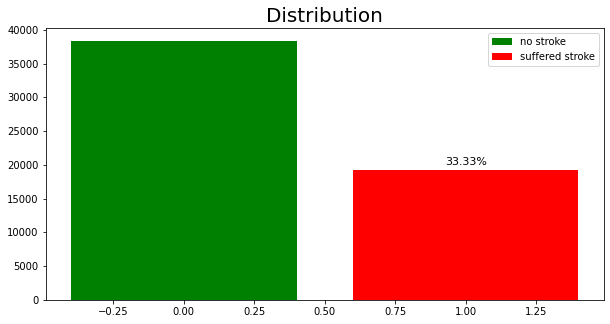

In [216]:
# cria dados sintéticos para equilibrar as classes
oversample = RandomOverSampler(sampling_strategy=0.5) 
X_over, y_over = oversample.fit_resample(x_tmp, y_tmp)

# vamos visualizar a distribuição agora
dados_temp = X_over.copy()
dados_temp["stroke"] = y_over
distribuicao(dados_temp)

# separa os dados numa proporção de teste e treino de 30%
x_treino,x_teste,y_treino,y_teste = train_test_split(X_over,y_over,test_size=0.3,stratify=y_over,random_state=42)

# Modelo

### Otimizadores

In [217]:
# alguns otimizadores testados
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0022)

optimizer_SGD = tf.keras.optimizers.SGD(
    learning_rate=0.02975,
    momentum=0.05,
    nesterov=False,
    name='SGD')

optimizer_Adagrad = tf.keras.optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.01,
    epsilon=1e-02,
    name="Adagrad",

)

### criando o modelo

In [218]:
# define um diretório para salvar as informações enquanto a rede neural é treinada
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# configuração do tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1,
    #write_images=True,
    write_steps_per_second=True,
    write_graph=True,)

# Gera uma instância de modelo sequencial
model = tf.keras.models.Sequential()
# adiciona as camadas
model.add(tf.keras.layers.Dense(30,activation=tf.nn.relu,input_shape=(x_treino.shape[1],)))
model.add(tf.keras.layers.Dense(40,activation=tf.nn.relu ))
model.add(tf.keras.layers.Dense(20,activation=tf.nn.sigmoid ))
model.add(tf.keras.layers.Dense(1,activation=tf.nn.sigmoid ))

# exibe informações do modelo
model.summary()

# compila o modelo
model.compile(optimizer=optimizer_adam,
              loss='MeanSquaredError',    
              metrics=['accuracy','Recall','AUC'])

# ativa um rastreamento de informações para ser visualizado no tensorboard,
# profiler = True pode implicar em alto consumo de memória
tf.summary.trace_on(graph=False, profiler=False)



Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 30)                480       
                                                                 
 dense_113 (Dense)           (None, 40)                1240      
                                                                 
 dense_114 (Dense)           (None, 20)                820       
                                                                 
 dense_115 (Dense)           (None, 1)                 21        
                                                                 
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


### Treinamento do modelo

In [219]:
#Treina o modelo
model.fit(x_treino,y_treino,batch_size=60, epochs=10,verbose=2,  validation_split=0.9,
          callbacks=[tensorboard_callback] # passa as configurações do tensorboard como parâmetro para a rede neural
          )

# testa o treinamento com os dados de teste
model.evaluate(x_teste,  y_teste, verbose=2)


# salva o modelo com seus pesos
model.save('save/model2/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Epoch 1/10
68/68 - 4s - loss: 0.2005 - accuracy: 0.6893 - recall: 0.2177 - auc: 0.7367 - val_loss: 0.1688 - val_accuracy: 0.7435 - val_recall: 0.5612 - val_auc: 0.8042 - 4s/epoch - 52ms/step
Epoch 2/10
68/68 - 1s - loss: 0.1614 - accuracy: 0.7576 - recall: 0.6017 - auc: 0.8269 - val_loss: 0.1588 - val_accuracy: 0.7659 - val_recall: 0.7225 - val_auc: 0.8336 - 1s/epoch - 18ms/step
Epoch 3/10
68/68 - 1s - loss: 0.1519 - accuracy: 0.7757 - recall: 0.6602 - auc: 0.8469 - val_loss: 0.1536 - val_accuracy: 0.7696 - val_recall: 0.7498 - val_auc: 0.8439 - 970ms/epoch - 14ms/step
Epoch 4/10
68/68 - 1s - loss: 0.1493 - accuracy: 0.7772 - recall: 0.7081 - auc: 0.8510 - val_loss: 0.1487 - val_accuracy: 0.7806 - val_recall: 0.6957 - val_auc: 0.8467 - 959ms/epoch - 14ms/step
Epoch 5/10
68/68 - 1s - loss: 0.1465 - accuracy: 0.7856 - recall: 0.7131 - auc: 0.8559 - val_loss: 0.1479 - val_accuracy: 0.7823 - val_recall: 0.7227 - val_auc: 0.8488 - 934ms/epoch - 14ms/step
Epoch 6/10
68/68 - 1s - loss: 0.1455

In [220]:
#teste com os dados de validação
model.evaluate(x_valida,  y_valida, verbose=2)

136/136 - 0s - loss: 0.1144 - accuracy: 0.8069 - recall: 0.7000 - auc: 0.8511 - 300ms/epoch - 2ms/step


[0.11440461128950119,
 0.8069124221801758,
 0.699999988079071,
 0.8510773181915283]

# Conversão do modelo para JSON

In [221]:
#salva o modelo e os pesos
model.save('logs/model.h5')

Utilizamos o JSON no front de uma página da web, sabemos que não é o melhor modo em escala de produção, mas estamos explorando a dimensão que o tensorflow pode oferecer 

In [222]:
#    --> Você pode chamar o tensorflowjs_converter no ambiente virtual:
# tensorflowjs_converter --input_format=keras logs/model.h5 server/public/model

# Submetendo a solução

In [223]:
"""
    Vamos enviar o conjunto de teste para realizar a predição
"""
# carrega o arquivo de teste disponibilizado no Hackathon
t = pd.read_csv("test.csv")
t.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [224]:
# normaliza os dados do dataset
tt = Normaliza_dados(t)
# exlcui a coluna id
tt = tt.drop('id',axis=1)
tt

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Private,work_type_Self-employed,work_type_Govt_job,work_type_Never_worked,smokes_formerly_smoked,smokes_never_smoked,smokes_smokes
0,0.0,0.80,0,0,0,0,0.117714,0.211,0,0,0,0,0,0,0
1,1.0,0.74,0,1,0,1,0.508163,0.260,1,0,0,0,0,0,0
2,1.0,0.14,0,0,1,1,0.163918,0.212,1,0,0,0,0,0,0
3,0.0,0.28,0,0,1,0,0.162286,0.234,1,0,0,0,0,0,0
4,1.0,0.63,0,0,0,1,0.116612,0.276,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18596,0.0,0.20,0,0,1,1,0.079306,0.184,1,0,0,0,0,0,0
18597,0.0,0.61,0,0,0,1,0.638980,0.316,1,0,0,0,0,0,0
18598,1.0,0.79,0,0,0,1,0.288735,0.294,1,0,0,0,0,0,0
18599,0.0,0.55,0,0,0,1,0.059020,0.338,0,0,1,0,0,0,0


In [225]:
# faz as predições dos dados de tt
valores = model.predict(tt)

#vamos juntar todas as colunas
df = t.copy()
# cria uma coluna  com os resultados da predição
df['stroke'] = valores
# remove as colunas desnecessárias para submeter
df.drop(["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"],axis=1,inplace=True)
# configura o id
df.reset_index(drop=True, inplace=True)
df['id'].set_index=True

# salva o arquivo
df.to_csv("final.csv",index=False)
df

582/582 [==============================] - 1s 2ms/step


,id,stroke
0,36306,0.736019
1,61829,0.801802
2,14152,0.016536
3,12997,0.080119
4,40801,0.028698
...,...,...
18596,67353,0.019526
18597,362,0.498969
18598,29839,0.683649
18599,6438,0.128195


In [227]:
v =["# Plotando os dados",
"### Função para plotar os gráficos",
"### Gráficos de distribuição dos dados",
"### Gráfico com várias colunas",
"# Normalizando os Dados",
"# Divisão dos dados",
"### Gerando dados sintéticos",
"# Modelo",
"### Otimizadores",
"### criando o modelo",
"### Treinamento do modelo",
"# Conversão do modelo para JSON",
"# Submetendo a solução",
]
for i in v:
    #- [Section 1](#Importando-as-bibliotecas)
    a = i.replace("# ",'#')
    b = "["+a.replace("#","")+"]"
    a = a.replace(" ",'-')
    a = '('+a+')'
    c = '-'+b+a
    c = c.replace("###","#")
    print(c)


-[Plotando os dados](#Plotando-os-dados)
-[Função para plotar os gráficos](#Função-para-plotar-os-gráficos)
-[Gráficos de distribuição dos dados](#Gráficos-de-distribuição-dos-dados)
-[Gráfico com várias colunas](#Gráfico-com-várias-colunas)
-[Normalizando os Dados](#Normalizando-os-Dados)
-[Divisão dos dados](#Divisão-dos-dados)
-[Gerando dados sintéticos](#Gerando-dados-sintéticos)
-[Modelo](#Modelo)
-[Otimizadores](#Otimizadores)
-[criando o modelo](#criando-o-modelo)
-[Treinamento do modelo](#Treinamento-do-modelo)
-[Conversão do modelo para JSON](#Conversão-do-modelo-para-JSON)
-[Submetendo a solução](#Submetendo-a-solução)
